# Breaking the Curse of Dimensionality via Half-Cycle Right Inference

This Colab notebook implements a simulation to verify the theorem that the half-cycle right inference trick can break the curse of dimensionality by leveraging structured priors and amortized inference. We compare standard bottom-up inference with inverted inference using a cycle-consistent generative loop.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# High-dimensional context (Psi) and low-dimensional structured content (Phi)
D = 100  # Context dimension
d = 8    # Structured latent content
k = 16    # Bottleneck dimension

N = 10000  # Number of samples

# Ground truth mapping: Phi -> Psi
true_decoder = nn.Sequential(
    nn.Linear(d, k),
    nn.ReLU(),
    nn.Linear(k, D)
).to(device)

# Sample structured content
Phi_true = torch.randn(N, d).to(device)
Psi = true_decoder(Phi_true).detach() + 0.05 * torch.randn(N, D).to(device)

train_loader = DataLoader(TensorDataset(Phi_true, Psi), batch_size=128, shuffle=True)


In [3]:
# Define encoder and decoder
def make_mlp(in_dim, out_dim, hidden_dim=64):
    return nn.Sequential(
        nn.Linear(in_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim)
    )

# Inverted inference modules
p_Z_given_Phi = make_mlp(d, k).to(device)
p_Psi_given_Z = make_mlp(k, D).to(device)

q_Z_given_Psi = make_mlp(D, k).to(device)
q_Phi_given_Z = make_mlp(k, d).to(device)

# Bottom-up regression
regressor = make_mlp(D, d).to(device)


In [4]:
# Half-cycle training
optimizer = optim.Adam(list(p_Z_given_Phi.parameters()) +
                       list(p_Psi_given_Z.parameters()) +
                       list(q_Z_given_Psi.parameters()) +
                       list(q_Phi_given_Z.parameters()), lr=1e-3)

loss_fn = nn.MSELoss()
for epoch in range(20):
    total_loss = 0
    for Phi_batch, Psi_batch in train_loader:
        Z = p_Z_given_Phi(Phi_batch)
        Psi_hat = p_Psi_given_Z(Z)
        Z_rec = q_Z_given_Psi(Psi_hat)
        Phi_rec = q_Phi_given_Z(Z_rec)
        loss = loss_fn(Phi_rec, Phi_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Inverted Inference] Epoch {epoch+1}, Loss: {total_loss:.4f}")


[Inverted Inference] Epoch 1, Loss: 60.4930
[Inverted Inference] Epoch 2, Loss: 24.1860
[Inverted Inference] Epoch 3, Loss: 10.7177
[Inverted Inference] Epoch 4, Loss: 5.8854
[Inverted Inference] Epoch 5, Loss: 0.8748
[Inverted Inference] Epoch 6, Loss: 0.5279
[Inverted Inference] Epoch 7, Loss: 0.4648
[Inverted Inference] Epoch 8, Loss: 0.4355
[Inverted Inference] Epoch 9, Loss: 0.3815
[Inverted Inference] Epoch 10, Loss: 0.3328
[Inverted Inference] Epoch 11, Loss: 0.2910
[Inverted Inference] Epoch 12, Loss: 0.2701
[Inverted Inference] Epoch 13, Loss: 0.2521
[Inverted Inference] Epoch 14, Loss: 0.2299
[Inverted Inference] Epoch 15, Loss: 0.2022
[Inverted Inference] Epoch 16, Loss: 0.1908
[Inverted Inference] Epoch 17, Loss: 0.1660
[Inverted Inference] Epoch 18, Loss: 0.1597
[Inverted Inference] Epoch 19, Loss: 0.1406
[Inverted Inference] Epoch 20, Loss: 0.1201


In [5]:
optimizer_reg = optim.Adam(regressor.parameters(), lr=1e-3)
for epoch in range(20):
    total_loss = 0
    for Phi_batch, Psi_batch in train_loader:
        Phi_pred = regressor(Psi_batch)
        loss = loss_fn(Phi_pred, Phi_batch)
        optimizer_reg.zero_grad()
        loss.backward()
        optimizer_reg.step()
        total_loss += loss.item()
    print(f"[Bottom-Up Regression] Epoch {epoch+1}, Loss: {total_loss:.4f}")


[Bottom-Up Regression] Epoch 1, Loss: 50.4398
[Bottom-Up Regression] Epoch 2, Loss: 19.9793
[Bottom-Up Regression] Epoch 3, Loss: 15.2853
[Bottom-Up Regression] Epoch 4, Loss: 14.2821
[Bottom-Up Regression] Epoch 5, Loss: 13.6807
[Bottom-Up Regression] Epoch 6, Loss: 13.0841
[Bottom-Up Regression] Epoch 7, Loss: 12.5690
[Bottom-Up Regression] Epoch 8, Loss: 12.0523
[Bottom-Up Regression] Epoch 9, Loss: 11.5891
[Bottom-Up Regression] Epoch 10, Loss: 11.1547
[Bottom-Up Regression] Epoch 11, Loss: 10.7250
[Bottom-Up Regression] Epoch 12, Loss: 10.3284
[Bottom-Up Regression] Epoch 13, Loss: 10.0470
[Bottom-Up Regression] Epoch 14, Loss: 9.7409
[Bottom-Up Regression] Epoch 15, Loss: 9.5666
[Bottom-Up Regression] Epoch 16, Loss: 9.3254
[Bottom-Up Regression] Epoch 17, Loss: 9.1421
[Bottom-Up Regression] Epoch 18, Loss: 8.9984
[Bottom-Up Regression] Epoch 19, Loss: 8.7791
[Bottom-Up Regression] Epoch 20, Loss: 8.7253


In [6]:
with torch.no_grad():
    Z = p_Z_given_Phi(Phi_true)
    Psi_hat_inv = p_Psi_given_Z(Z)
    Z_rec = q_Z_given_Psi(Psi_hat_inv)
    Phi_rec = q_Phi_given_Z(Z_rec)

    Phi_pred_reg = regressor(Psi)

    mse_inv = loss_fn(Phi_rec, Phi_true).item()
    mse_reg = loss_fn(Phi_pred_reg, Phi_true).item()

    print(f"Bottom-Up Regression MSE: {mse_reg:.4f}")
    print(f"Inverted Inference MSE: {mse_inv:.4f}")


Bottom-Up Regression MSE: 0.1089
Inverted Inference MSE: 0.0015


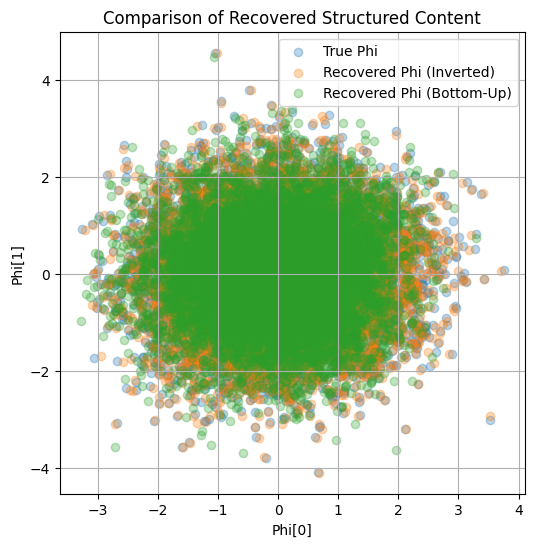

In [7]:
plt.figure(figsize=(6, 6))
plt.scatter(Phi_true[:, 0].cpu(), Phi_true[:, 1].cpu(), alpha=0.3, label='True Phi')
plt.scatter(Phi_rec[:, 0].cpu(), Phi_rec[:, 1].cpu(), alpha=0.3, label='Recovered Phi (Inverted)')
plt.scatter(Phi_pred_reg[:, 0].cpu(), Phi_pred_reg[:, 1].cpu(), alpha=0.3, label='Recovered Phi (Bottom-Up)')
plt.legend()
plt.title("Comparison of Recovered Structured Content")
plt.xlabel("Phi[0]")
plt.ylabel("Phi[1]")
plt.grid(True)
plt.show()
